In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotli
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [ ]:
from rotated_yolov1 import *
def labels2bbox(matrix):
    """
    将网络输出的7*7*30的数据转换为bbox的(98,25)的格式，然后再将NMS处理后的结果返回
    :param matrix: 注意，输入的数据中，bbox坐标的格式是(px,py,w,h)，需要转换为(x1,y1,x2,y2)的格式再输入NMS
    :return: 返回NMS处理后的结果
    """
    if matrix.size()[0:2]!=(7,7):
        raise ValueError("Error: Wrong labels size:",matrix.size())
    bbox = torch.zeros((98,15))
    # 先把7*7*30的数据转变为bbox的(98,25)的格式，其中，bbox信息格式从(px,py,w,h)转换为(x1,y1,x2,y2),方便计算iou
    for i in range(7):  # i是网格的行方向(y方向)
        for j in range(7):  # j是网格的列方向(x方向)
            bbox[2*(i*7+j),0:4] = torch.Tensor([(matrix[i, j, 0] + j) / 7 - matrix[i, j, 2] / 2,
                                                (matrix[i, j, 1] + i) / 7 - matrix[i, j, 3] / 2,
                                                (matrix[i, j, 0] + j) / 7 + matrix[i, j, 2] / 2,
                                                (matrix[i, j, 1] + i) / 7 + matrix[i, j, 3] / 2])
            bbox[2 * (i * 7 + j), 4] = matrix[i,j,4]
            bbox[2 * (i * 7 + j), 5] = matrix[i,j,5]
            bbox[2*(i*7+j),6:] = matrix[i,j,12:]
    
            bbox[2*(i*7+j)+1,0:4] = torch.Tensor([(matrix[i, j, 6] + j) / 7 - matrix[i, j, 8] / 2,
                                                (matrix[i, j, 7] + i) / 7 - matrix[i, j, 9] / 2,
                                                (matrix[i, j, 6] + j) / 7 + matrix[i, j, 8] / 2,
                                                (matrix[i, j, 7] + i) / 7 + matrix[i, j, 9] / 2])
            bbox[2 * (i * 7 + j)+1, 4] = matrix[i, j, 10]
            bbox[2 * (i * 7 + j)+1, 5] = matrix[i, j, 11]
            bbox[2*(i*7+j)+1,6:] = matrix[i,j,12:]
    #return bbox
    #print(bbox.shape)
    return NMS(bbox)  # 对所有98个bbox执行NMS算法，清理cls-specific confidence score较低以及iou重合度过高的bbox
def NMS(bbox, conf_thresh=0.05, iou_thresh=0.05):
    """bbox数据格式是(n,15),前5个是(x1,y1,x2,y2,theta)的坐标信息，第6个是置信度，后9个是类别概率
    :param conf_thresh: cls-specific confidence score的阈值
    :param iou_thresh: NMS算法中iou的阈值
    """
    n = bbox.size()[0]
    bbox_prob = bbox[:,6:].clone()  # 类别预测的条件概率
    bbox_confi = bbox[:, 5].clone().unsqueeze(1).expand_as(bbox_prob)  # 预测置信度
    bbox_cls_spec_conf = bbox_confi*bbox_prob  # 置信度*类别条件概率=cls-specific confidence score整合了是否有物体及是什么物体的两种信息
    bbox_cls_spec_conf[bbox_cls_spec_conf<=conf_thresh] = 0  # 将低于阈值的bbox忽略
    for c in range(9):
        rank = torch.sort(bbox_cls_spec_conf[:,c],descending=True).indices
        for i in range(98):
            if bbox_cls_spec_conf[rank[i],c]!=0:
                for j in range(i+1,98):
                    if bbox_cls_spec_conf[rank[j],c]!=0:
                        iou = skewiou(bbox[rank[i],0:4],bbox[rank[j],0:4],bbox[rank[i],4],bbox[rank[j],4])
                        if iou > iou_thresh:  # 根据iou进行非极大值抑制抑制
                            bbox_cls_spec_conf[rank[j],c] = 0
    bbox = bbox[torch.max(bbox_cls_spec_conf,dim=1).values>0]  # 将20个类别中最大的cls-specific confidence score为0的bbox都排除
    bbox_cls_spec_conf = bbox_cls_spec_conf[torch.max(bbox_cls_spec_conf,dim=1).values>0]
    res = torch.ones((bbox.size()[0],7))
    res[:,1:6] = bbox[:,0:5]  # 储存最后的bbox坐标信息
    res[:,0] = torch.argmax(bbox[:,6:],dim=1).int()  # 储存bbox对应的类别信息
    res[:,6] = torch.max(bbox_cls_spec_conf,dim=1).values  # 储存bbox对应的class-specific confidence scores
    return res

def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)

In [ ]:
res = labels2bbox(pred)

In [17]:
def get_rotated_p(x, y, rx, ry, theta):
    n_x = (x-rx)*np.cos(theta)-(y-ry)*np.sin(theta)+rx
    n_y = (x-rx)*np.sin(theta)+(y-ry)*np.cos(theta)+ry
    return (n_x, n_y)
    
def get_rotated_rec(x1, y1, x2, y2, theta):
    cy = (y2+y1)/2
    cx = (x1+x2)/2
    p1 = get_rotated_p(x2, y1, cx, cy, theta)
    p2 = get_rotated_p(x2, y2, cx, cy, theta)
    p3 = get_rotated_p(x1, y1, cx, cy, theta)
    p4 = get_rotated_p(x1, y2, cx, cy, theta)
    
    return [p1, p2, p4, p3]

In [18]:
bbox = []
cls = []

# x1 = 800*bbox[i,1]
# y1 = 800*bbox[i,2]
# x2 = 800*bbox[i,3]
# y2 = 800*bbox[i,4]
# point_squence = torch.tensor([[x1,y1],[x2, y1],[x2,y2], [x1,y2], [x1,y1]])

for i in res:
    tmp = []
    p1, p2, p4, p3 = get_rotated_rec(i[1], i[2], i[3], i[4], i[5])
    tmp.append(p1)
    tmp.append(p2)
    tmp.append(p3)
    tmp.append(p4)
#     tmp.append([i[1],i[2]])
#     tmp.append([i[3],i[2]])
#     tmp.append([i[1],i[4]])
#     tmp.append([i[3],i[4]])  
#     tmp.append([i[2],i[1]])
#     tmp.append([i[2],i[3]])
#     tmp.append([i[4],i[1]])
#     tmp.append([i[4],i[3]])  
    
    bbox.append(list(np.array(tmp).T))
    cls.append(i[0])
    
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(np.array(bbox)):
    draw_box(ax, torch.Tensor(bb*80-40), color=color_list[int(cls[i])])
plt.show()

NameError: name 'res' is not defined

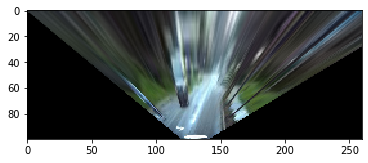

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_H = 100#256#223
IMAGE_W = 260#1280

src = np.float32([[0, 256], [306, 256], [0, 130], [IMAGE_W, 130]])
dst = np.float32([[120, IMAGE_H], [140, IMAGE_H], [0, 0], [IMAGE_W, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

img = cv2.imread('../data/scene_0/sample_102/CAM_FRONT.jpeg') # Read the test img
#img = image[1].numpy().transpose(1,2,0)[:,0]
#img = img[450:(450+IMAGE_H), 0:IMAGE_W] # Apply np slicing for ROI crop
warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results
plt.show()

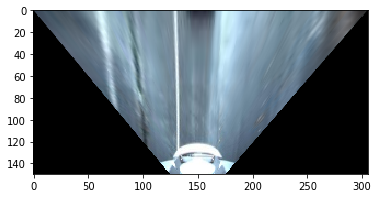

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_H = 150#256#223
IMAGE_W = 306#1280

src = np.float32([[0, 230], [306, 230], [0, 150], [IMAGE_W, 150]])
dst = np.float32([[125, IMAGE_H], [175, IMAGE_H], [0, 0], [IMAGE_W, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

img = cv2.imread('../data/scene_0/sample_102/CAM_BACK.jpeg') # Read the test img
#img = image[1].numpy().transpose(1,2,0)[:,0]
#img = img[450:(450+IMAGE_H), 0:IMAGE_W] # Apply np slicing for ROI crop
warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results
plt.show()

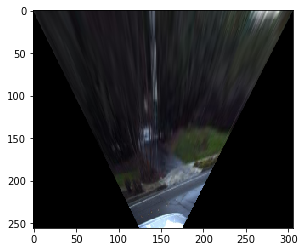

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_H = 256#223
IMAGE_W = 306#1280

src = np.float32([[0, IMAGE_H], [306, IMAGE_H], [0, 125], [IMAGE_W, 125]])
dst = np.float32([[125, IMAGE_H], [175, IMAGE_H], [0, 0], [IMAGE_W, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

img = cv2.imread('../data/scene_0/sample_0/CAM_FRONT_LEFT.jpeg') # Read the test img
#img = image[1].numpy().transpose(1,2,0)[:,0]
#img = img[450:(450+IMAGE_H), 0:IMAGE_W] # Apply np slicing for ROI crop
warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results
plt.show()